# changelog

mas de 2 elementos, eliminar lineas precautorias

In [29]:
import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages as pdf
import seaborn as sns
sns.set_style("darkgrid")

import requests 
import json
import importlib
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import os

ruta_archivo = os.getcwd()
ruta_base =os.path.dirname(ruta_archivo)

## Parametros

In [30]:
carpeta_dispersion = '/../02_Archivos/GraficasDispersion'

# faenas = ['Radomiro Tomic','Antucoya','Quebrada Blanca','Collahuasi','Gaby','Los Pelambres','Caserones','Cerro Negro Norte','Andina','Centinela','Ministro Hales','Escondida','Sierra Gorda','Spence','Lomas Bayas']
# 'Collahuasi', 'Lomas Bayas', 'Radomiro Tomic', 'SPENCE', 'Gaby','Cerro Negro Norte', 'Antucoya', 'Sierra Gorda', 'Qblanca','Caserones', 'Andina', 'Los Pelambres', 'Chuquicamata','Esperanza Sur', 'Esperanza', 'Ministro Hales'
faena ='Cerro Negro Norte'

# Equipos a graficar
# flota_completa = False 
# flotas ='WA 1200'
# True: Graficas todos los equipos de 'flotas', no considera 'lista_unidades'
# False: Grafica equipos de 'lista_unidades'
lista_equipos = ['CF02']

# Fecha minima de datos2022-07-20
#fecha  ='2021-01-19'
desde  ='2022-07-20'
hoy = dt.date.today()
hasta = hoy.strftime('%Y-%m-%d')
# hasta = ""

# elementos = ['AL', 'Agua', 'B', 'CA', 'CR', 'CU', 'Diluc.', 'FE', 'Hollin','Ind.PQ.', 'K', 'MG', 'MO', 'NI', 'Nitrac.', 'Oxid.', 'P', 'PB', 'SI', 'SN', 'Sulf.', 'TBN', 'Visc 100', 'Visc.40', 'ZN']
grupo_elementos = [['SI','AL'],['NA','K'],['B'],['Visc 100'],['Diluc.'],['Agua'],['TBN'],['Hollin'],['Oxid.','Sulf.','Nitrac.'],['Ind.PQ.'],['CR'],['CU'],['FE'],['PB'],['ZN','P'],['MG'],['CA'],[ 'MO']]

In [31]:
subcarpeta = True


In [32]:
guardar_dispersion = os.path.abspath(ruta_base + carpeta_dispersion)

carpeta_scaa = 'DatosScaa'
carpeta_scaa = os.path.abspath(ruta_base + '/../02_Archivos/' + carpeta_scaa)
carpeta_limites = 'DatosLimites'
carpeta_limites = os.path.abspath(ruta_base + '/../02_Archivos/' + carpeta_limites)

## Datos Limites

In [33]:
# Leer limites condenatorios
datos_limites = pd.read_csv(carpeta_limites +'\\limites.csv',keep_default_na=False)

In [34]:
datos_limites.elemento.unique()

array(['AL', 'Agua', 'B', 'CA', 'CR', 'CU', 'Diluc.', 'FE', 'Hollin',
       'Ind.PQ.', 'K', 'MG', 'MO', 'NA', 'NI', 'Nitrac.', 'Oxid.', 'P',
       'PB', 'SI', 'SN', 'TBN', 'Visc 100', 'Visc.40', 'ZN'], dtype=object)

In [35]:
limites = datos_limites.copy()
limites = limites[limites.faena == faena]

limites['desde'] = pd.to_datetime(limites['desde'])  
limites['hasta'] = pd.to_datetime(limites['hasta'])  

filtro_fecha_limite = ((limites['desde'] > desde) & (limites['desde'] <= hasta)) | (limites['hasta'] >= hasta)
limites = limites.loc[filtro_fecha_limite]
# limites = limites[limites.flotas == flota]

filtro_flotas = '|'.join([x.replace(" ", ".*") for x in limites.flota.unique()])

In [36]:
limites.elemento.unique()

array(['AL', 'Agua', 'B', 'CA', 'CR', 'CU', 'Diluc.', 'FE', 'Hollin',
       'Ind.PQ.', 'K', 'MG', 'MO', 'NA', 'NI', 'Nitrac.', 'Oxid.', 'P',
       'PB', 'SI', 'SN', 'TBN', 'Visc 100', 'Visc.40', 'ZN'], dtype=object)

## Datos SCAA

In [37]:
datos_scaa = pd.read_csv(carpeta_scaa + '\\consolidado_scaa.csv', index_col='Nro.Muestra')

In [38]:
scaa = datos_scaa.copy()

# filtro faena
scaa = scaa[scaa.Faena == faena]
scaa = scaa[scaa.Componente == 'Motor Diesel']
scaa = scaa[scaa.Modelo.str.contains(filtro_flotas)]
scaa['Equipo'] =pd.Series(scaa['Equipo'].str.split('.').str[0], dtype="string")
# pd.Series(scaa['Equipo'], dtype="string").applymap(lambda x: '{0:.0f}'.format(x))

scaa['Fecha Muestra'] = pd.to_datetime(scaa['Fecha Muestra'],format='%d/%m/%Y')
# Filtro fechas

filtro_fecha_scaa = (scaa['Fecha Muestra'] > desde) & (scaa['Fecha Muestra'] <= hasta)
scaa = scaa.loc[filtro_fecha_scaa]

scaa.sort_values(by='Fecha Muestra', inplace = True) 

scaa.reset_index(drop=True, inplace=True)

In [39]:
# leer unidades de elementos
f = open(carpeta_limites +'\\unidades.json')
unidades = json.load(f)
f.close()

In [40]:
def si_carpeta(carpeta):
    guardar_carpeta = os.path.abspath(carpeta)
    # directory = save_path + '\\' + carpeta_guardado 
    if not os.path.exists(guardar_carpeta):
        os.makedirs(guardar_carpeta)

def fecha_limites(temp_limites,date, tipo):
    for index, row in temp_limites.iterrows():
        if row[0]< pd.Timestamp(date):
            return row[tipo]

def ruta_guardar_grafico(carpeta_tendencias,faena,flota,eq,Fecha,subcarpeta):
    if subcarpeta:
        carpeta = ruta_base + carpeta_tendencias + '/' + faena + ' - ' + flota + '/'
        si_carpeta(carpeta)
        return  carpeta +faena+' CA-'+eq+' Fecha '+Fecha+'.pdf'
    else: 
        return ruta_base + carpeta_tendencias + '/' + faena +' CA-'+eq+' Fecha '+Fecha+'.pdf'

## Grafica de datos

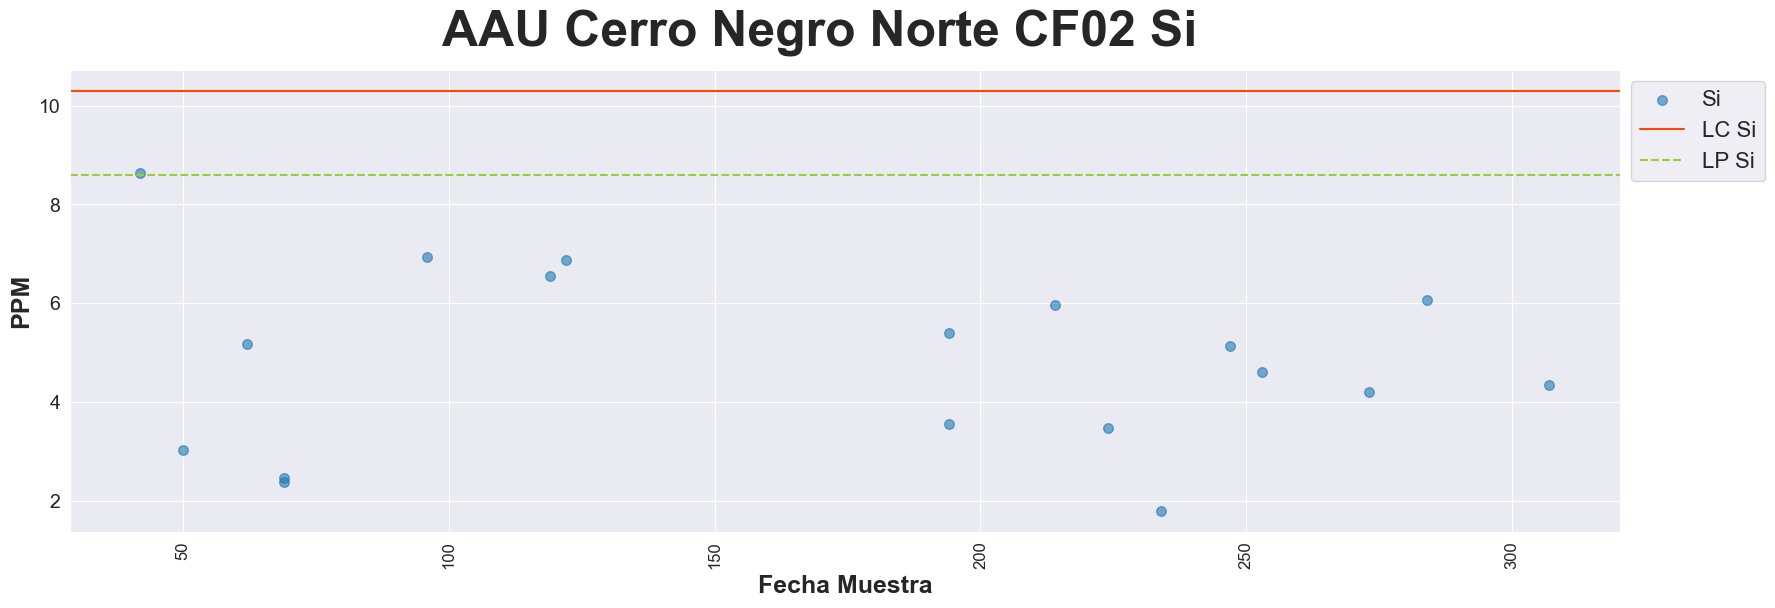

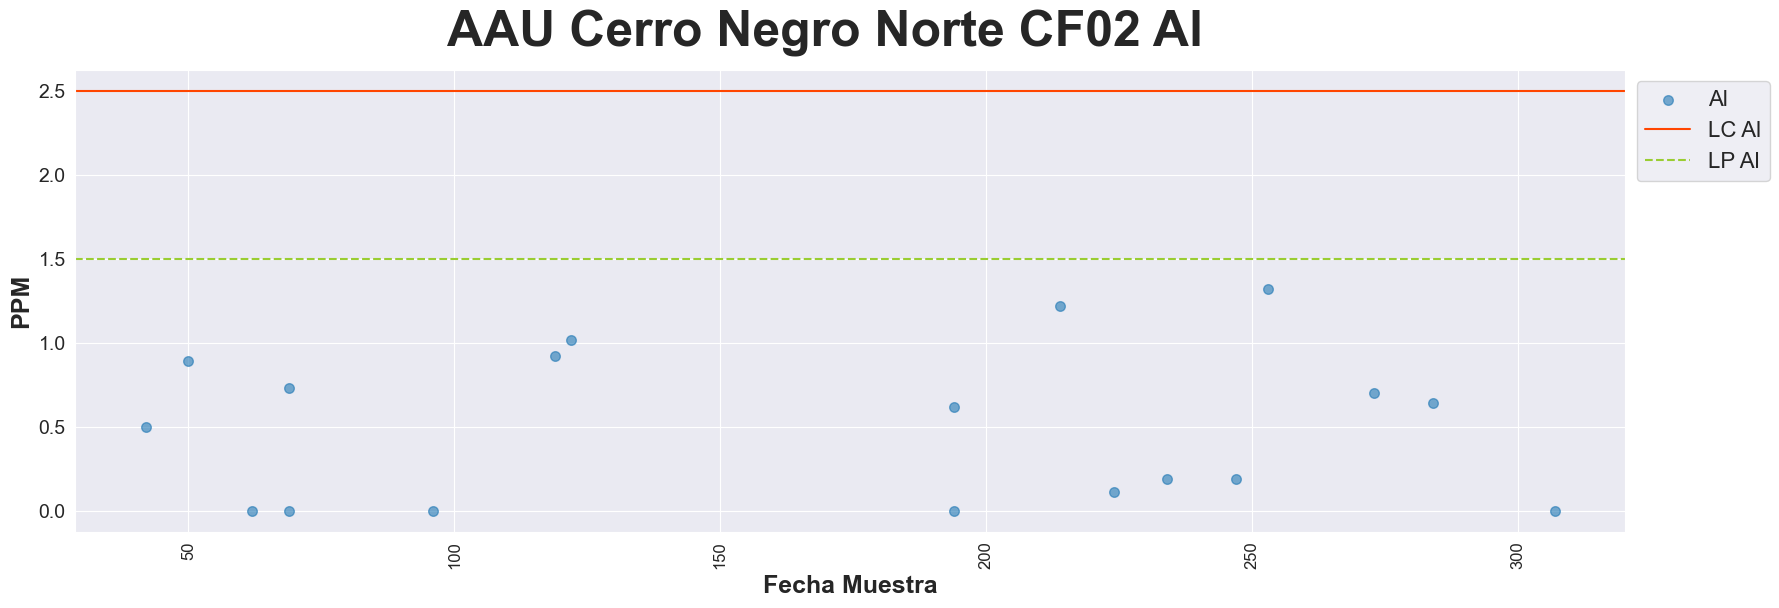

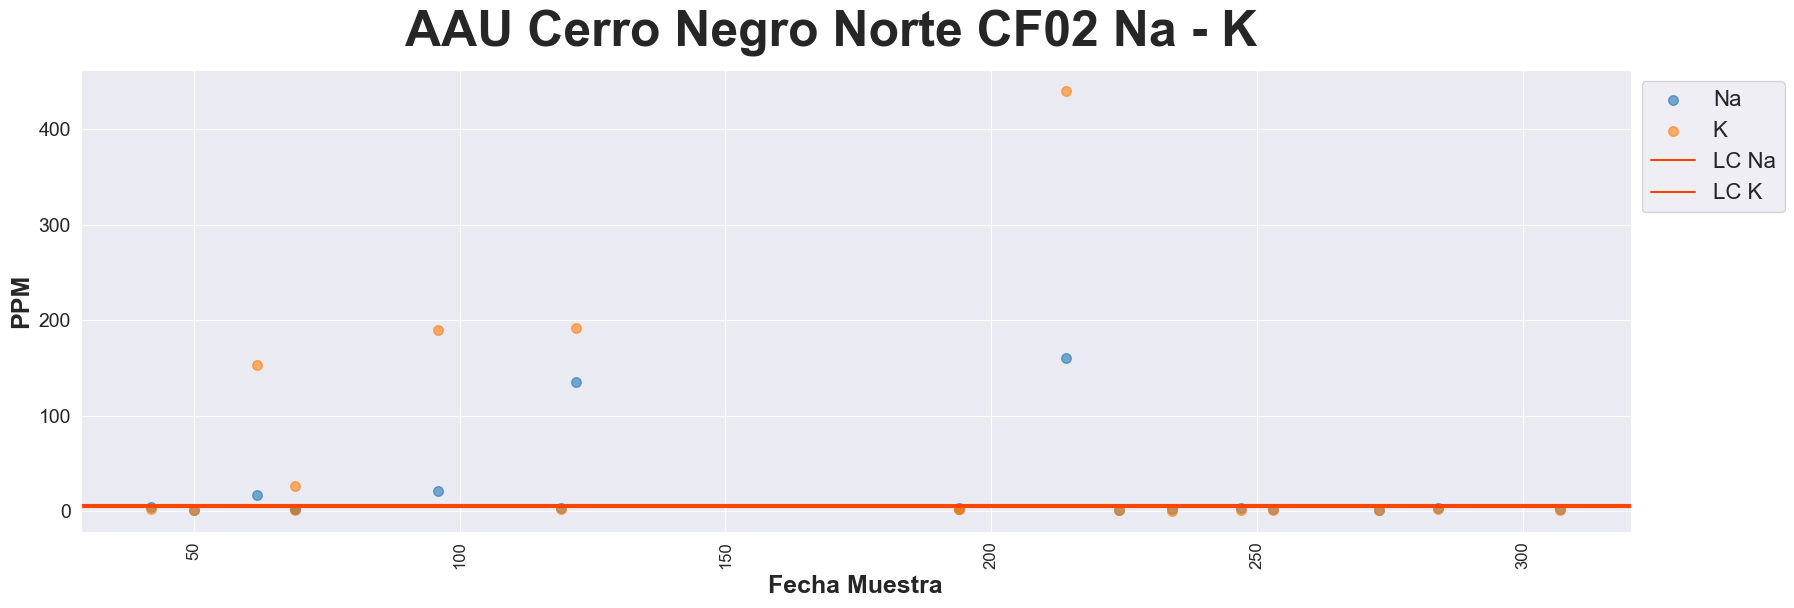

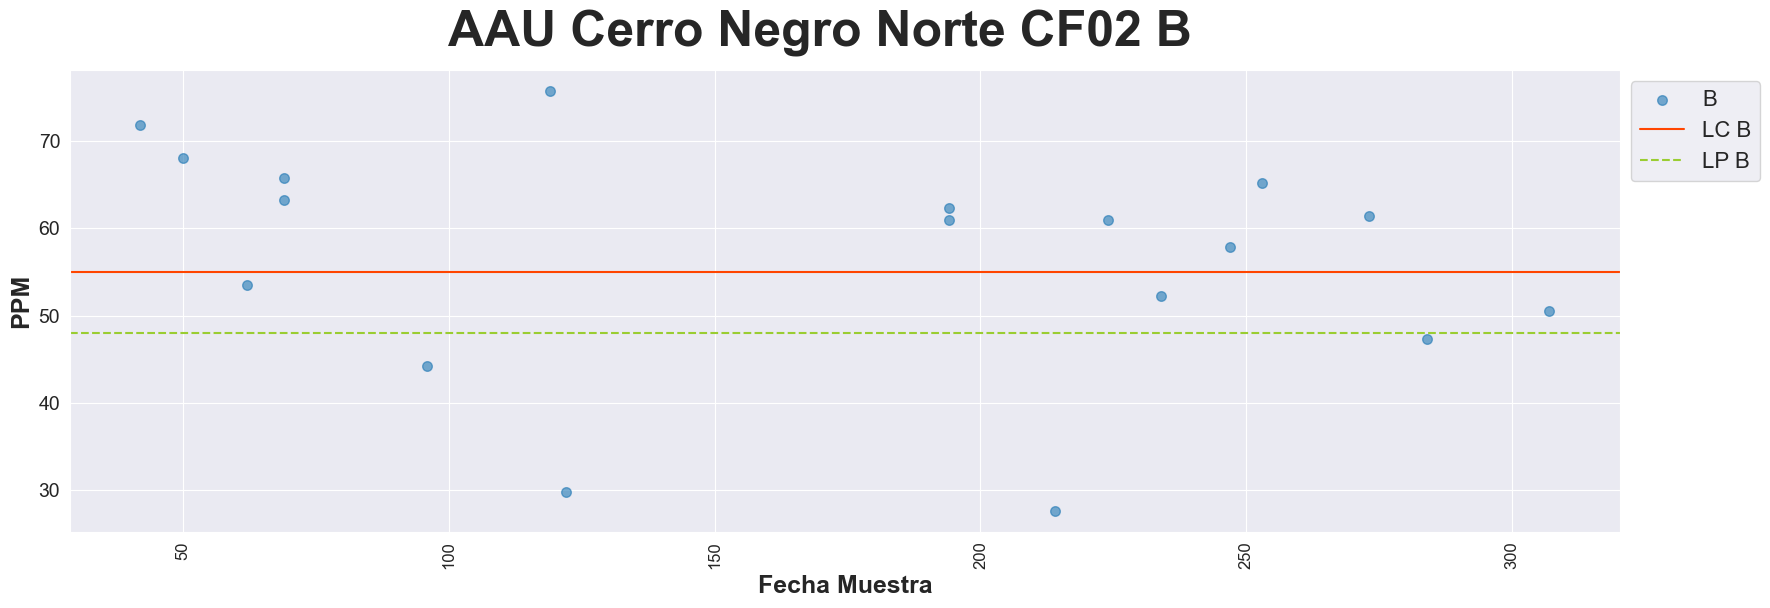

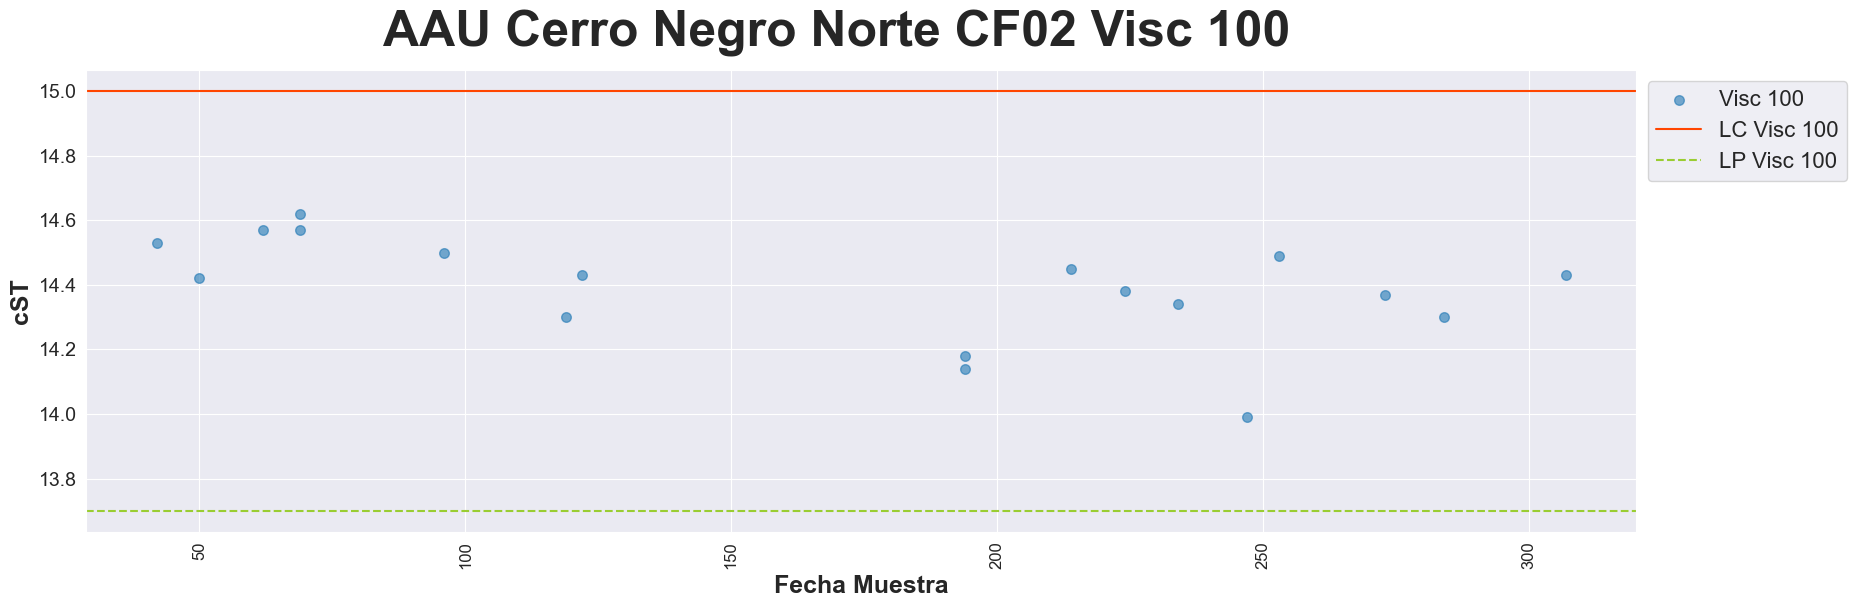

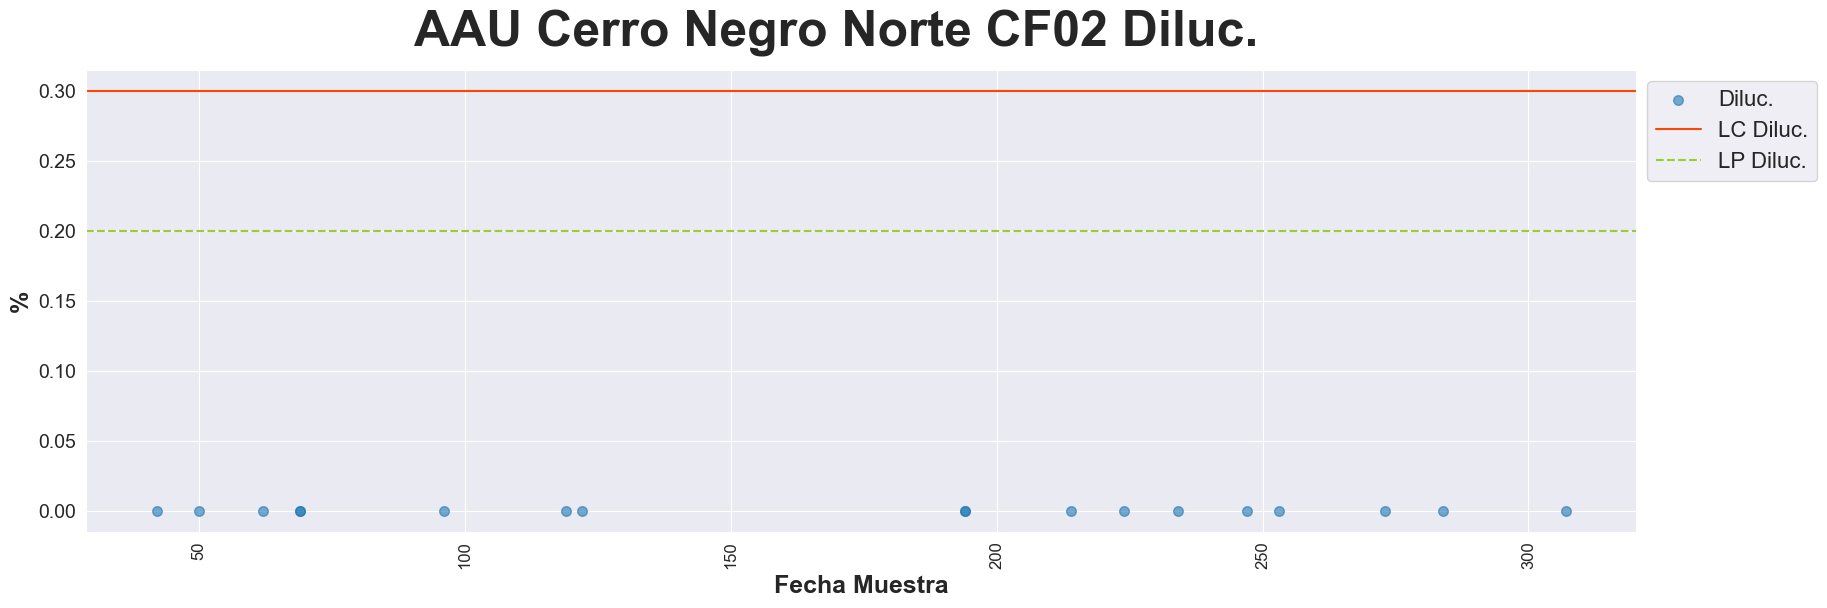

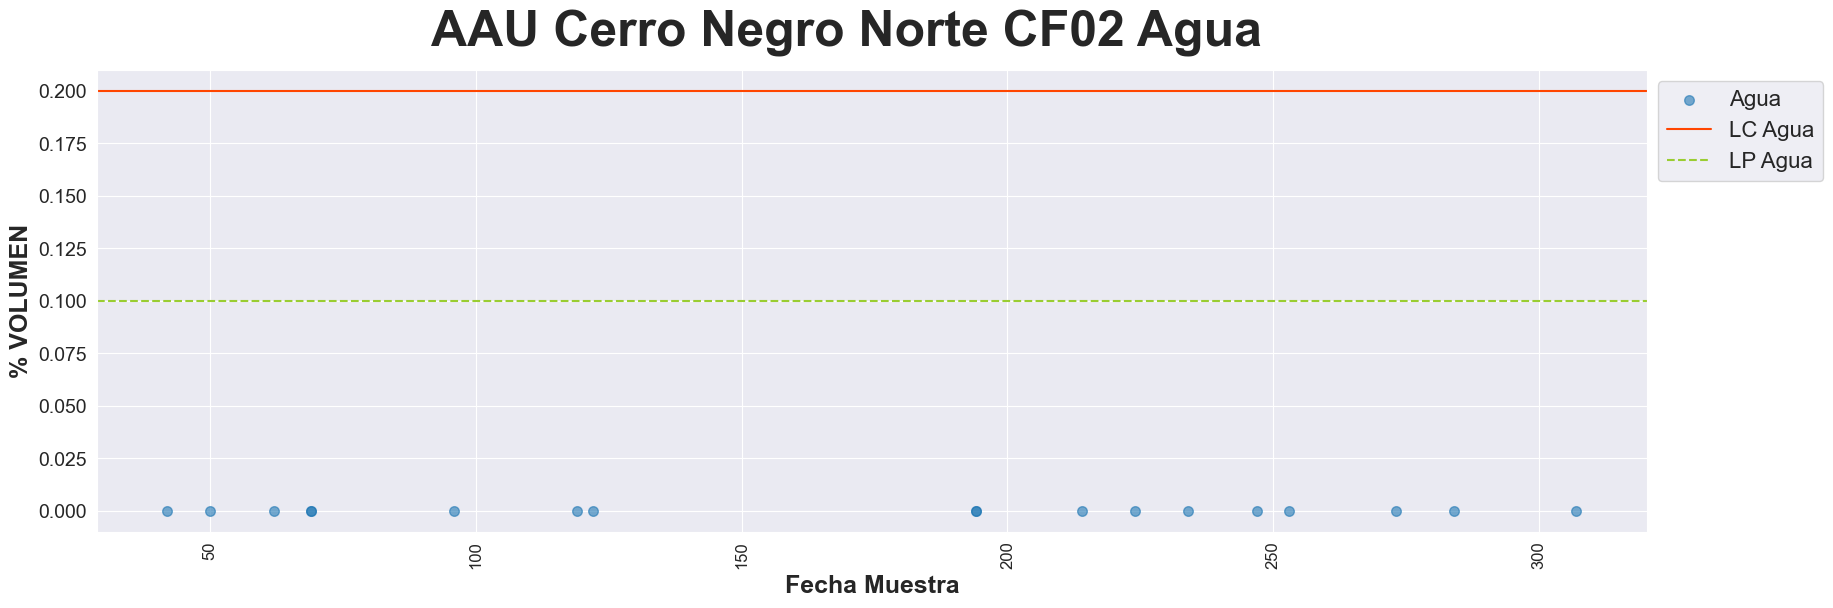

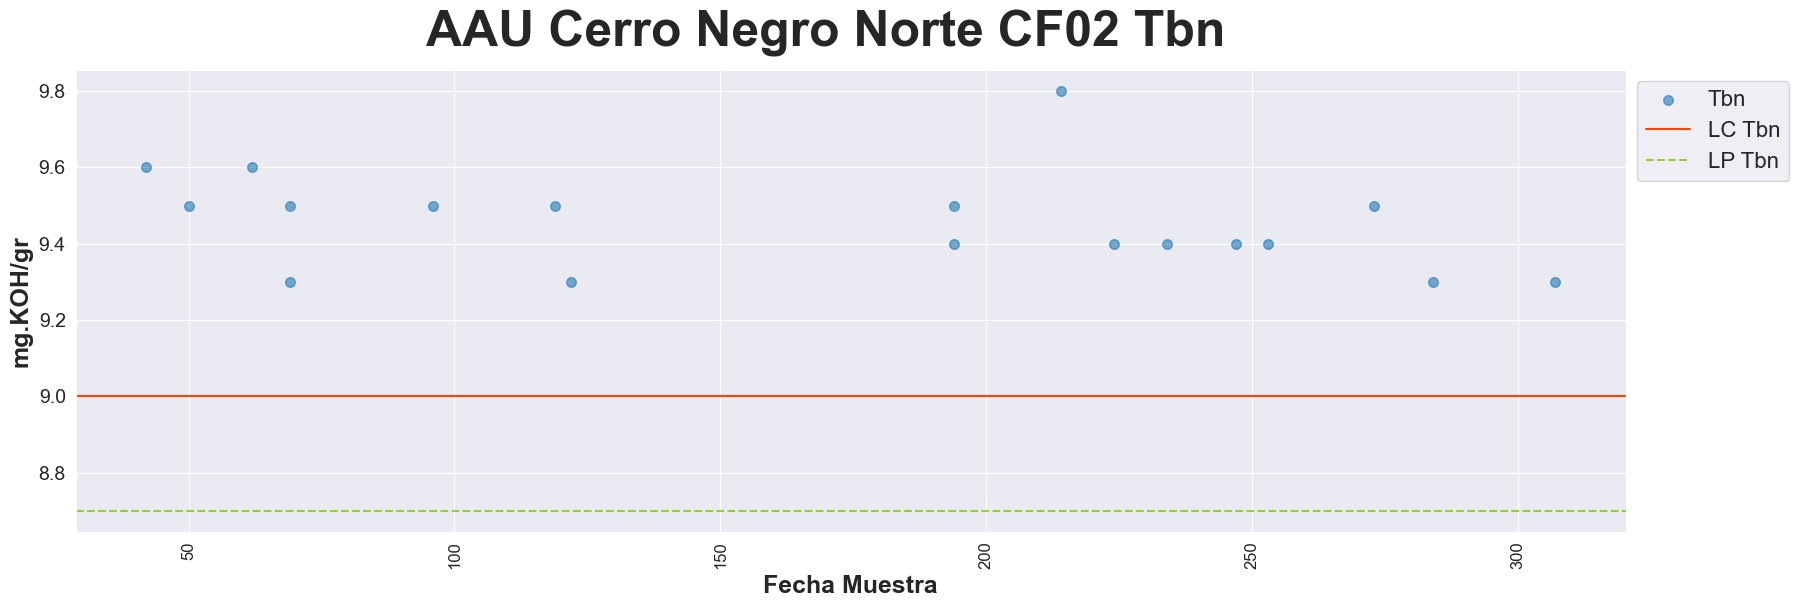

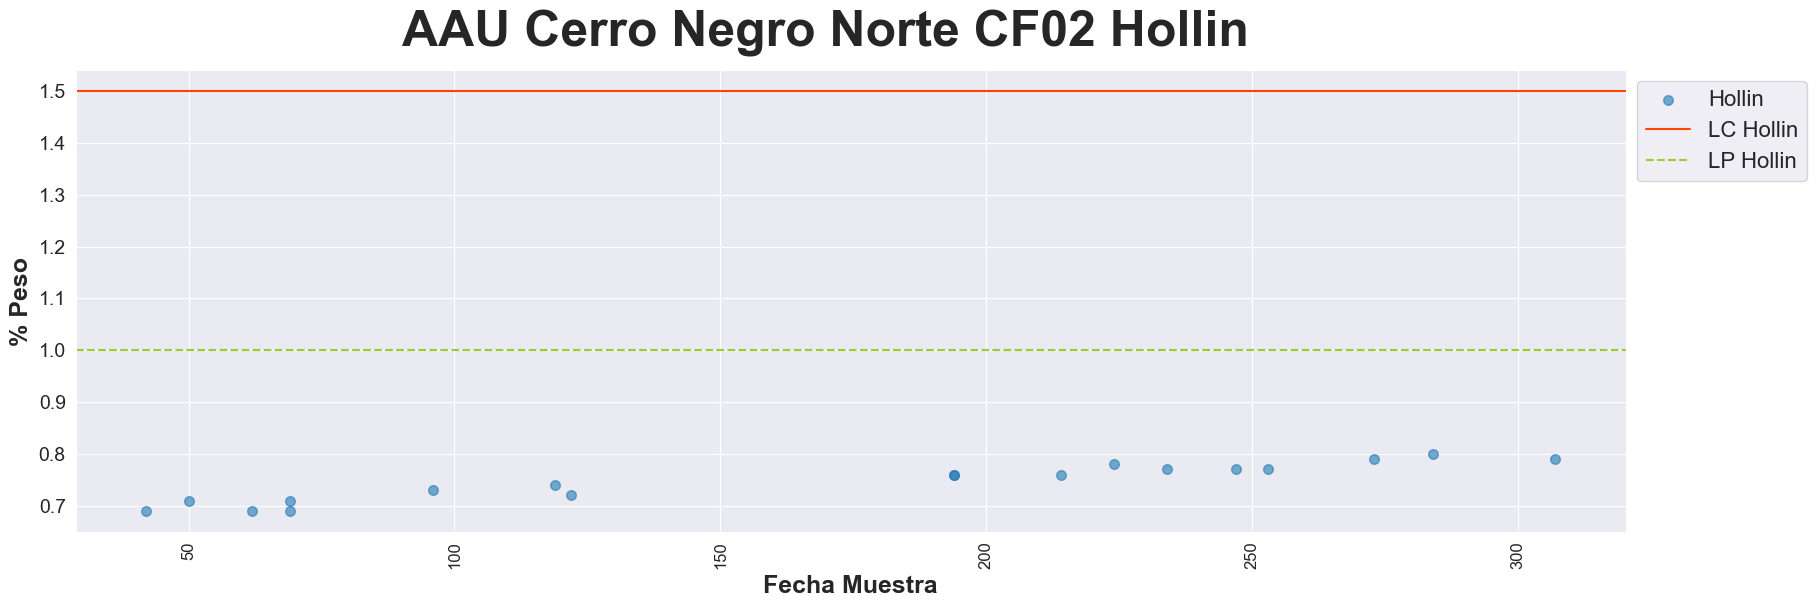

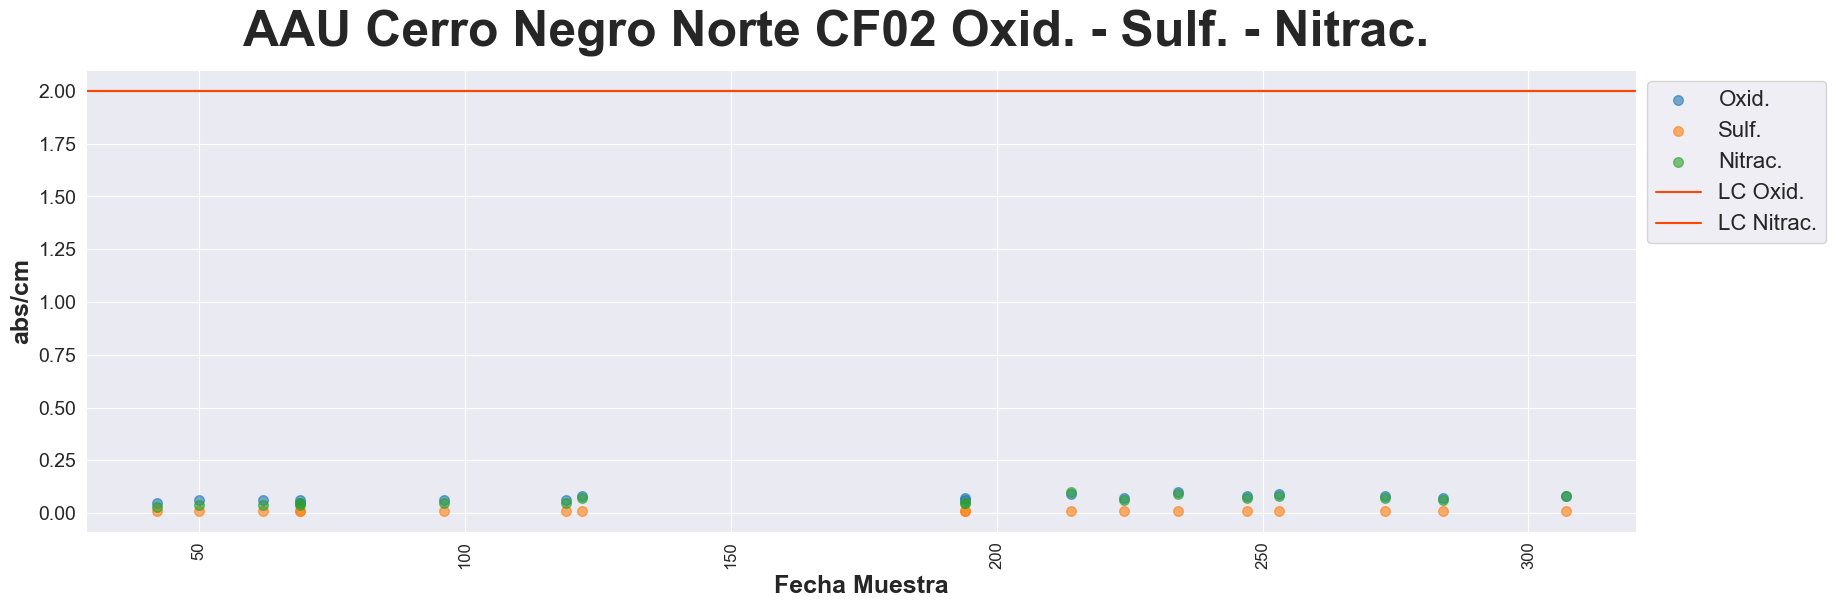

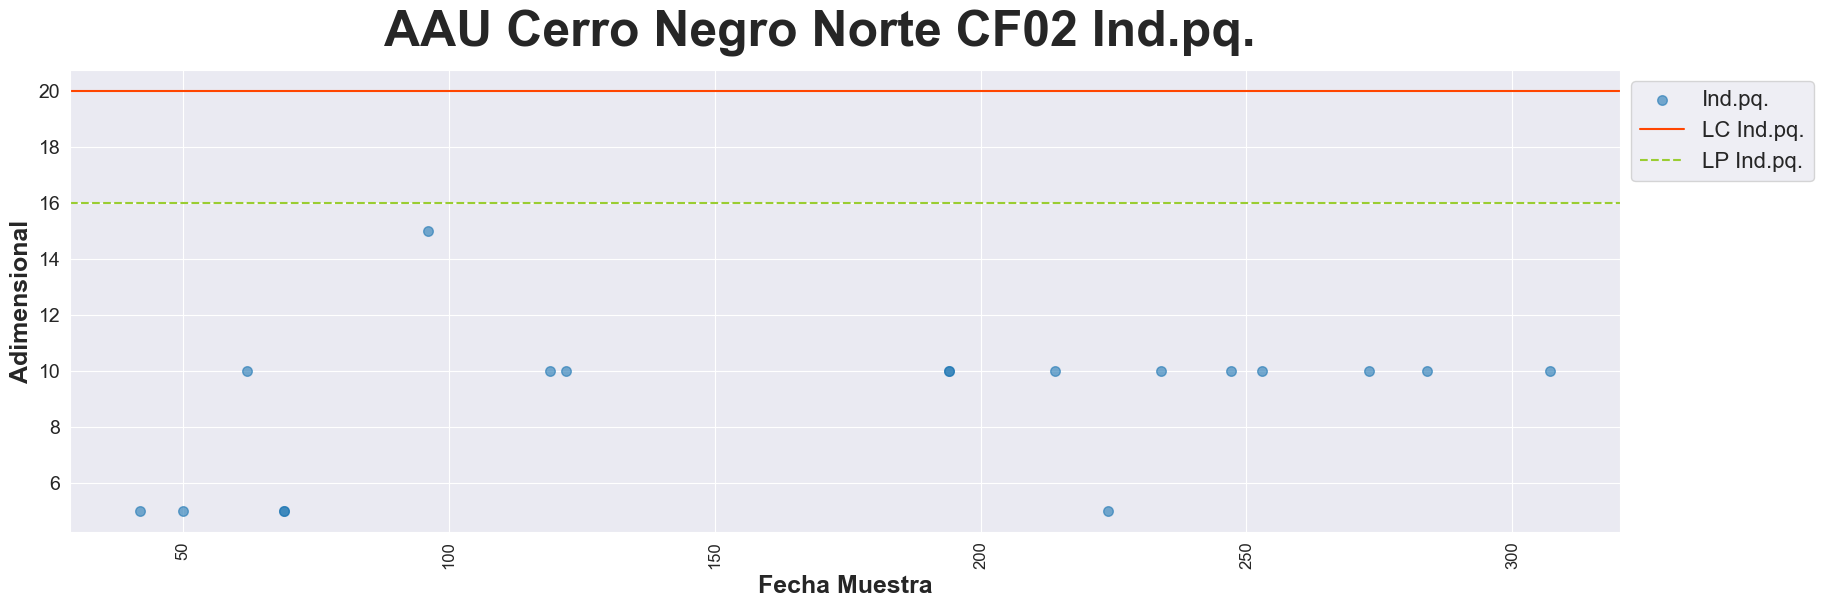

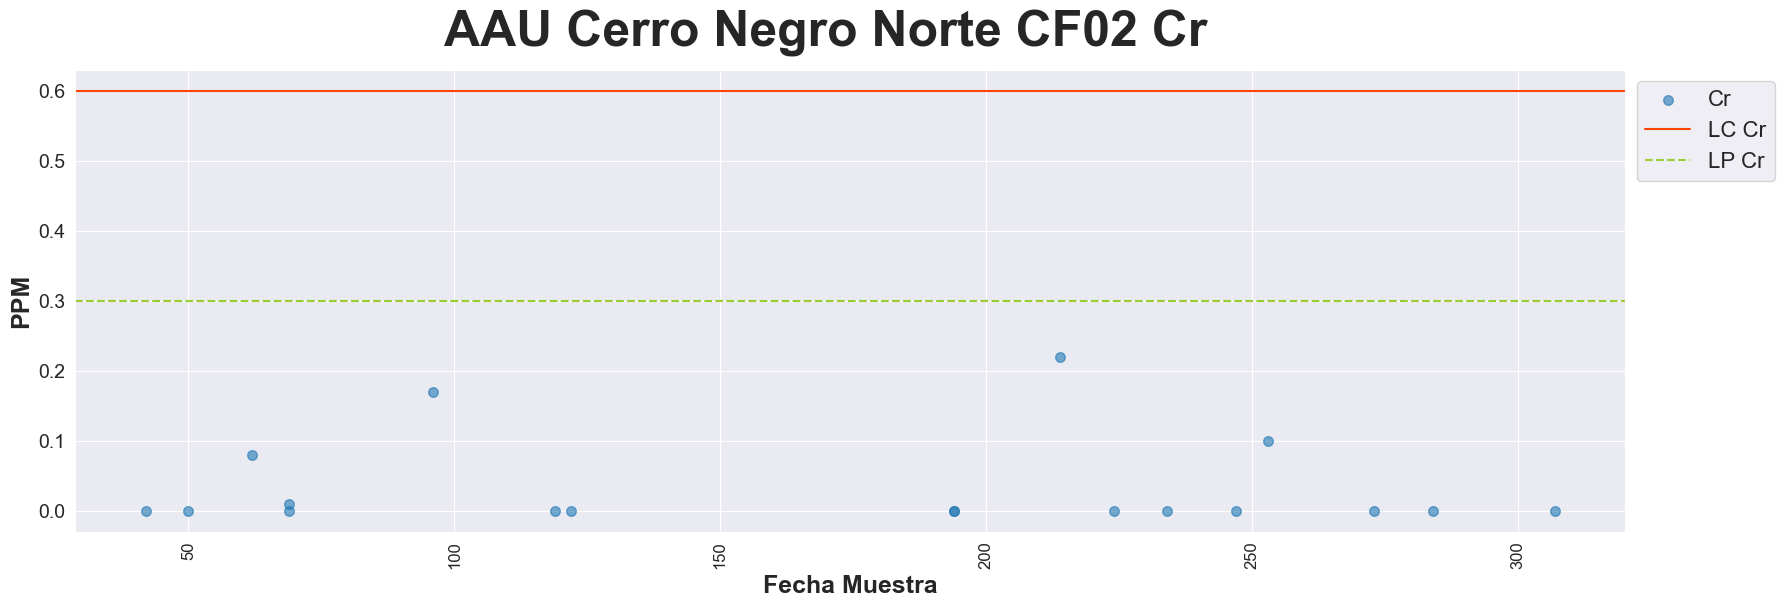

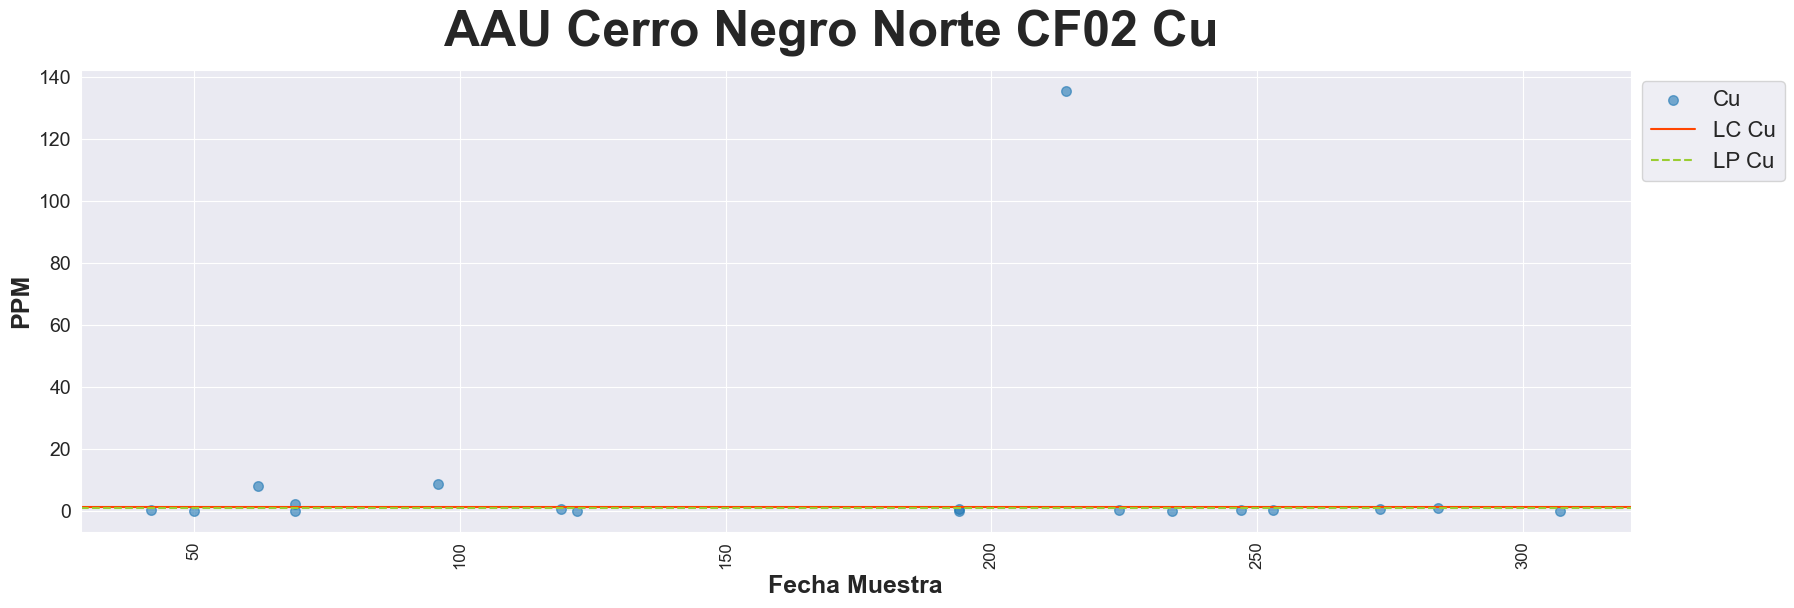

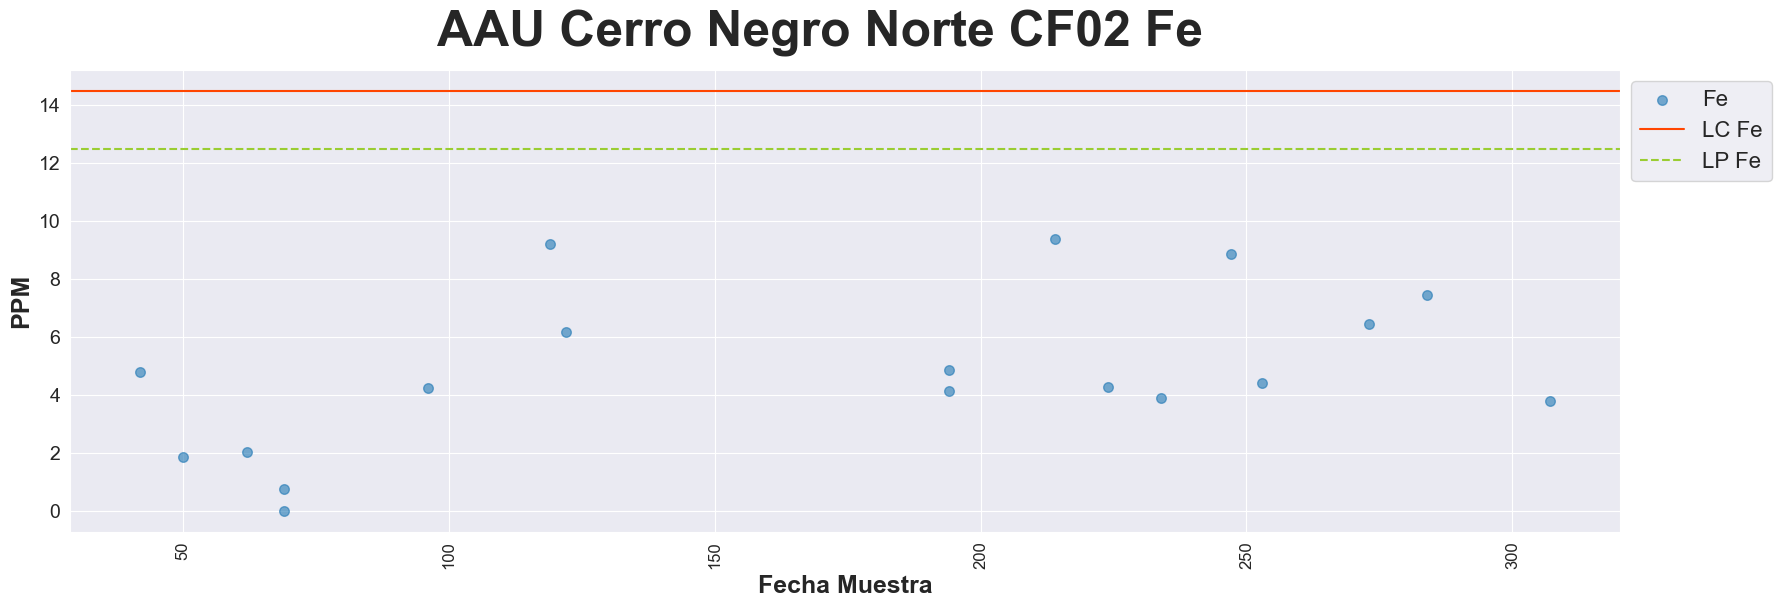

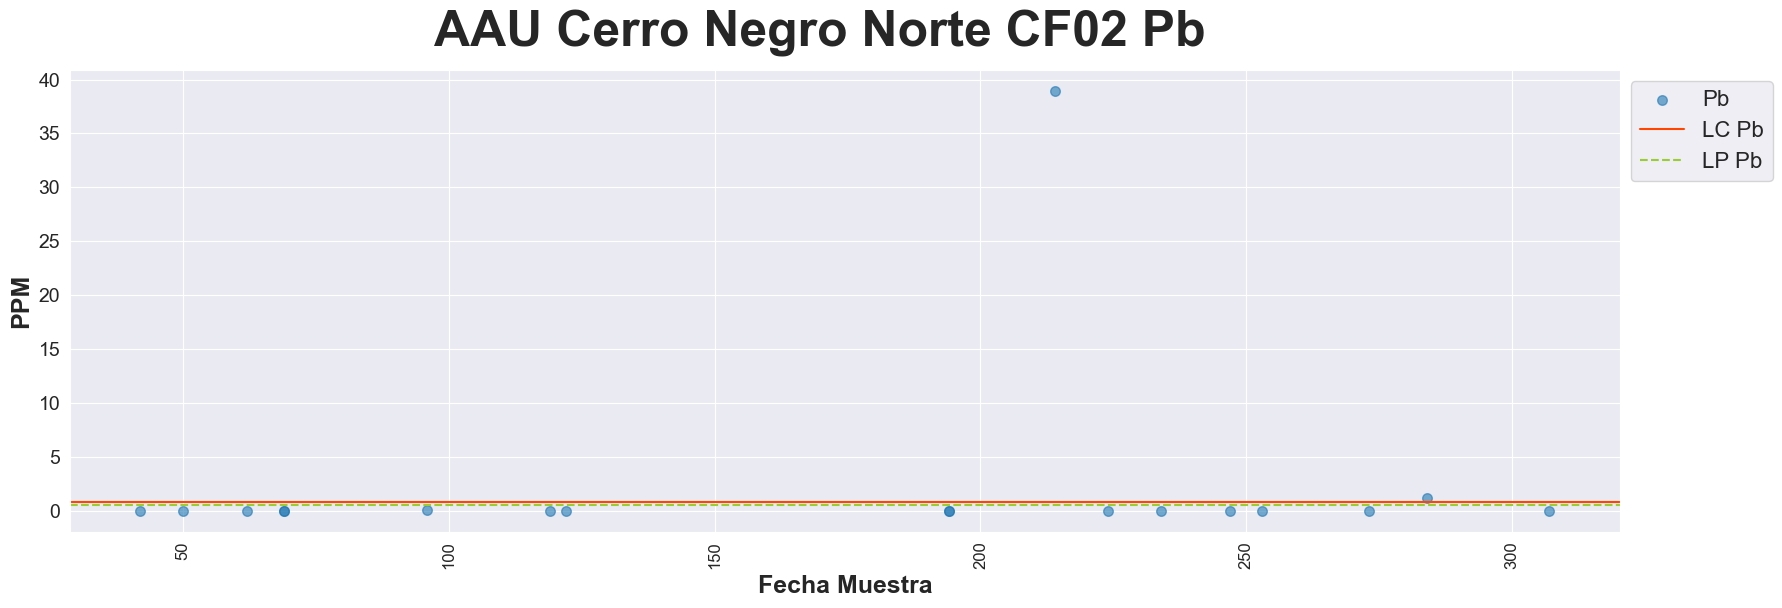

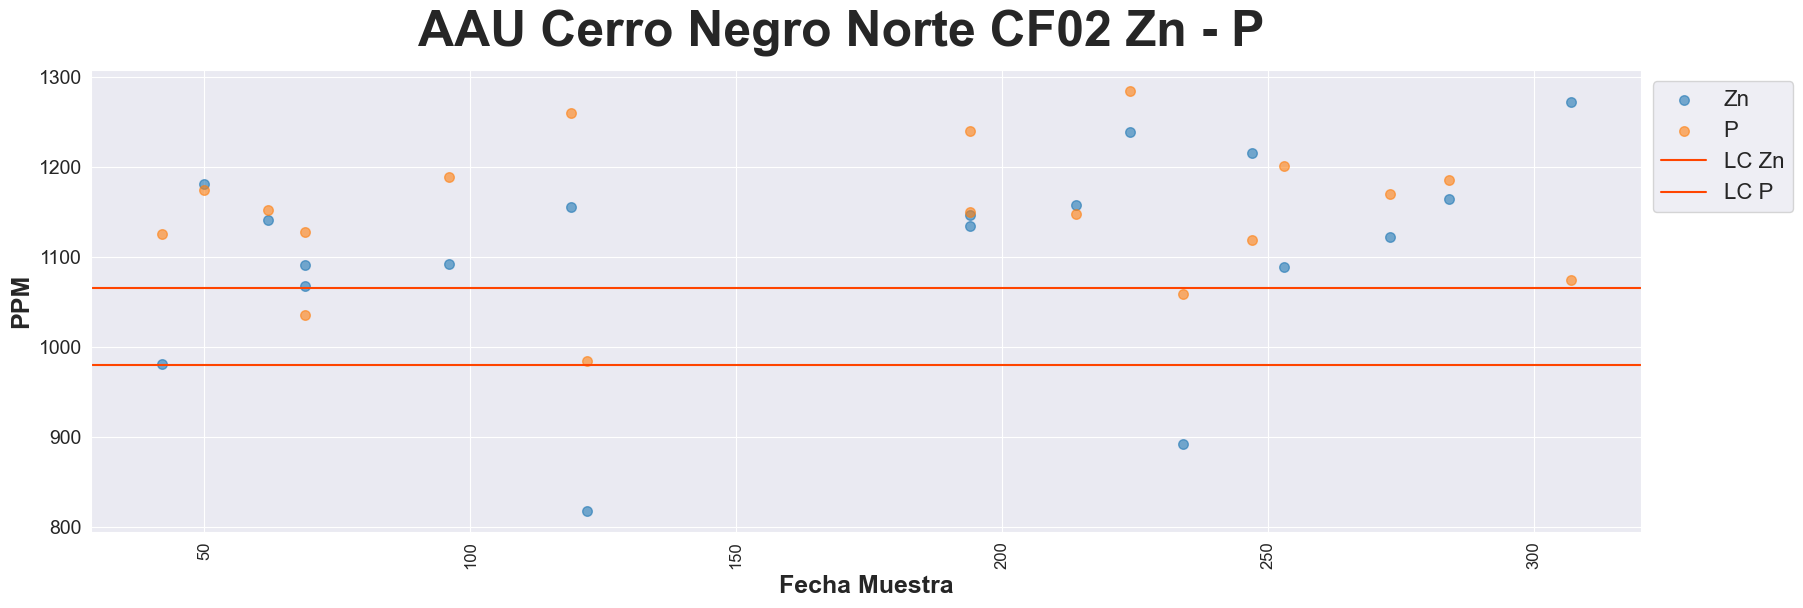

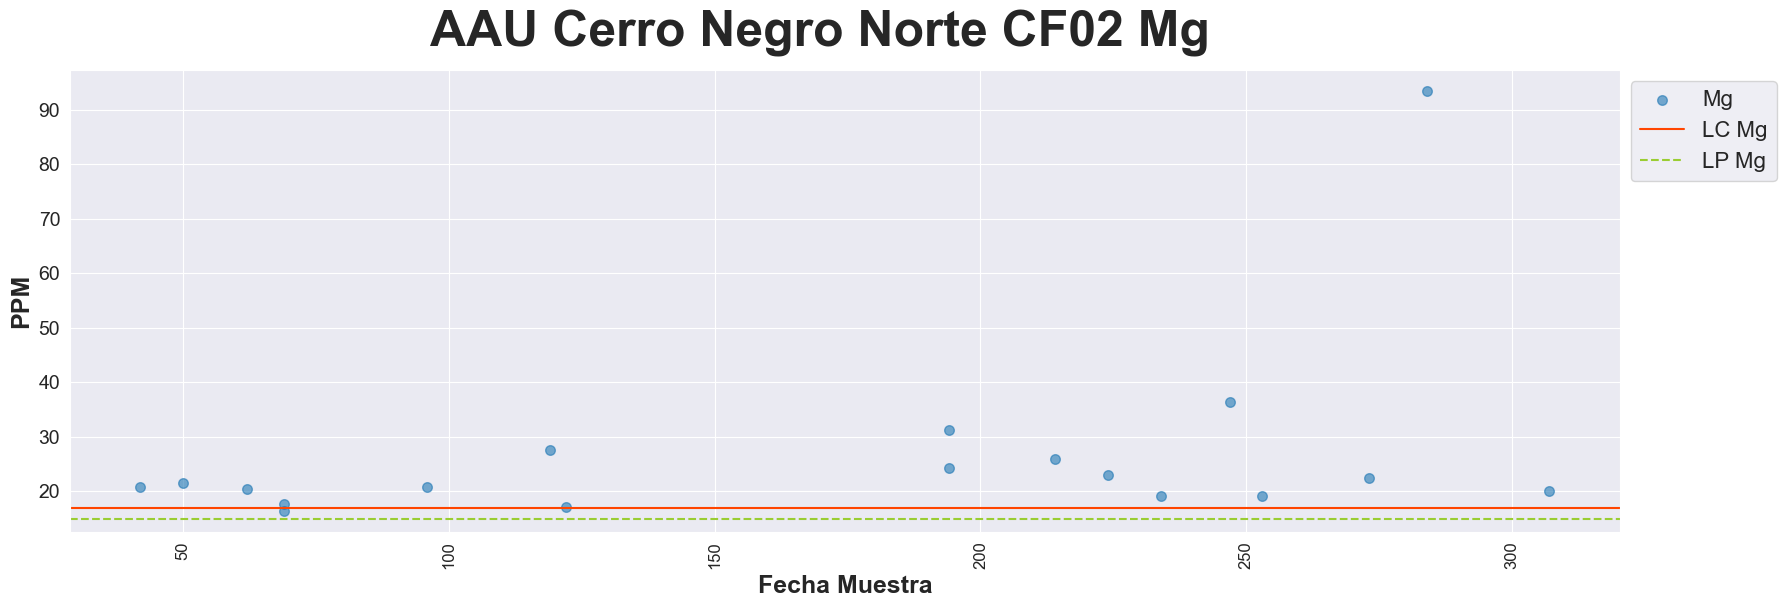

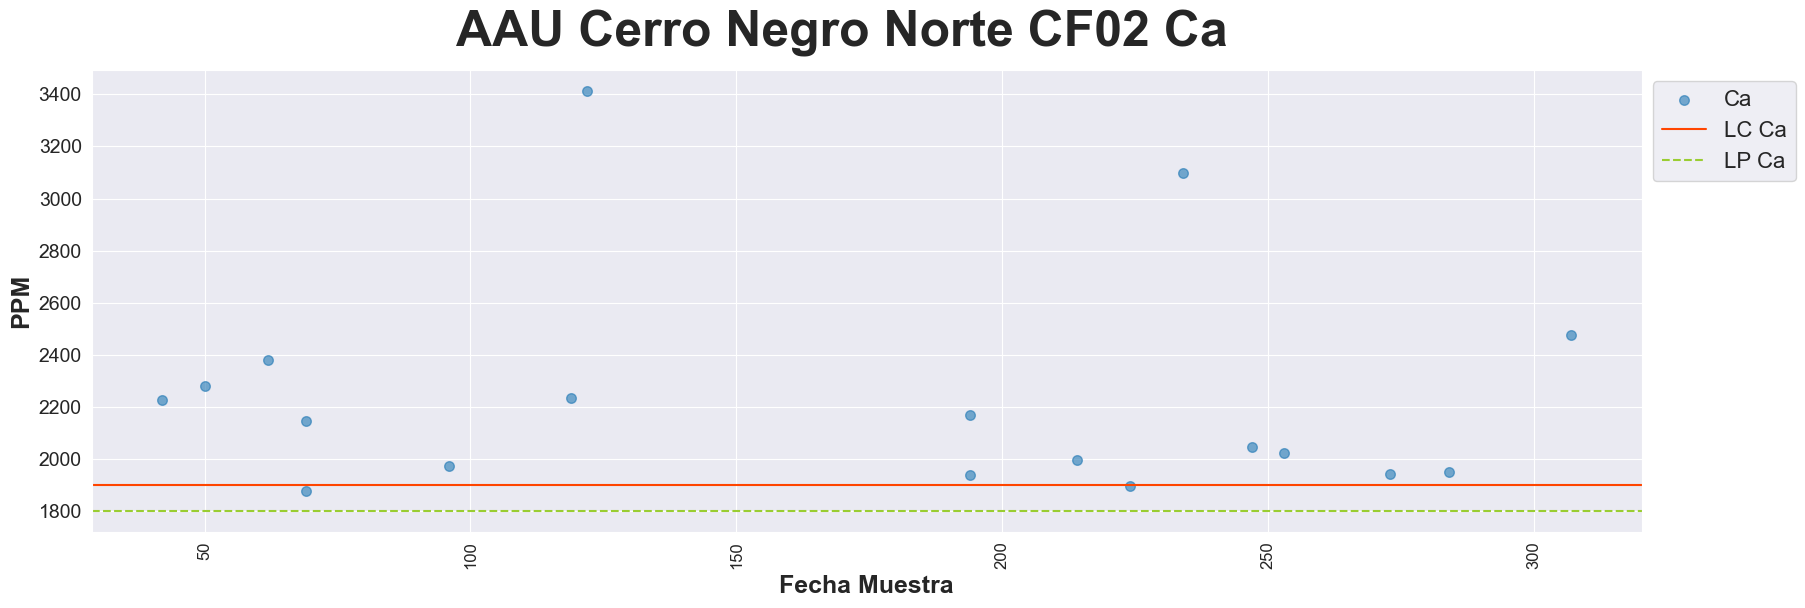

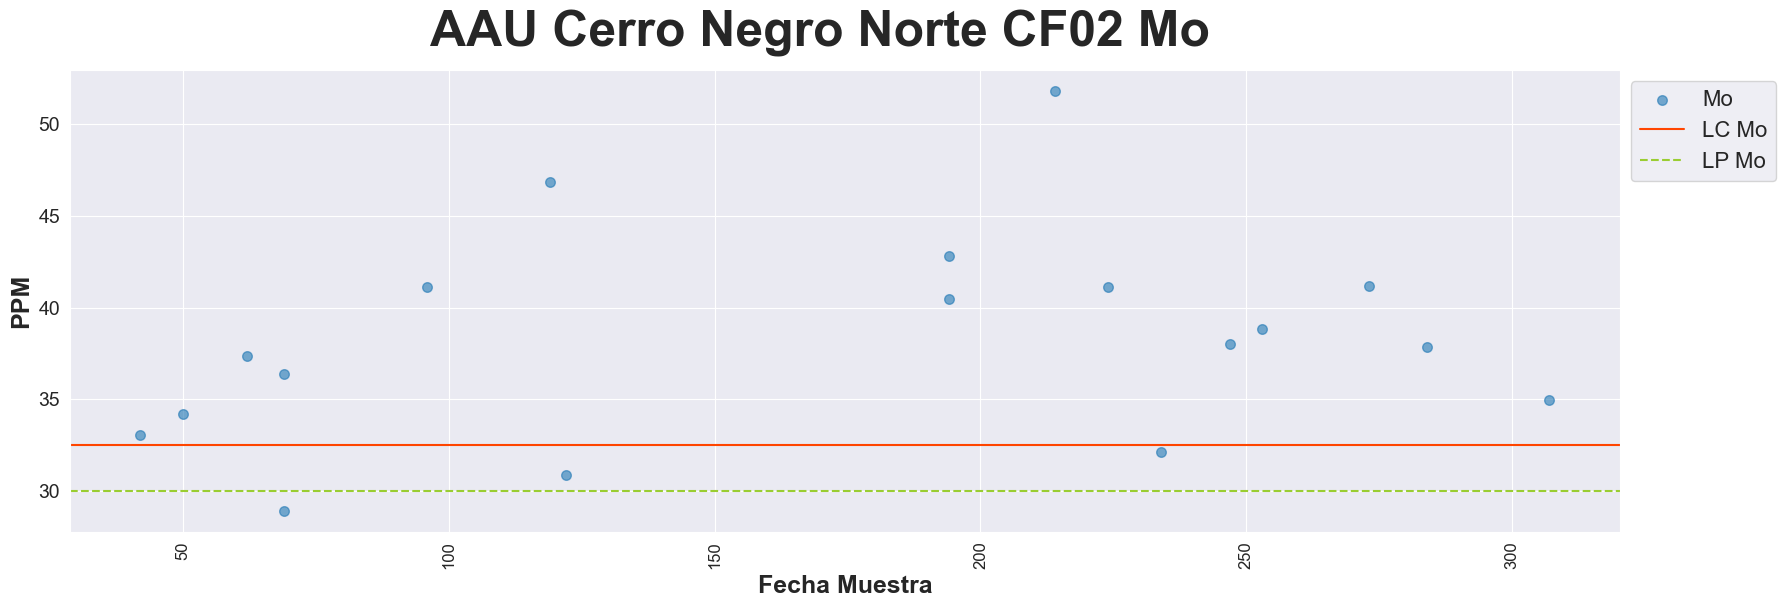

In [53]:

eje_x = 'Horas Aceite'

  
for equipo in lista_equipos:
    scaa_equipo = scaa.copy()[scaa['Equipo'].isin([equipo])]

    modelo_equipo = scaa_equipo.Modelo.iloc[0].replace("'","")
    with pdf(ruta_guardar_grafico(carpeta_dispersion,faena,modelo_equipo,equipo,hasta,subcarpeta)) as image: 
        for elementos in grupo_elementos:
            elementos_capitalizados = list(map(lambda x: x.capitalize(), elementos))
            titulo_elementos = ' - '.join(elementos_capitalizados)

            fig = plt.figure(figsize=(20,6))
            ax = fig.add_subplot(111)  

            # Filtro de limites para el equipo
            
            limites_equipo = limites.copy()
            limites_equipo = limites_equipo[limites_equipo.flota.apply(lambda x:bool(re.search(x.replace(' ','.*'),modelo_equipo)))]
            # Titulo de grafico
            plt.suptitle("AAU "+faena+" "+ equipo +" "+titulo_elementos,fontsize=36,fontweight="bold")


            # Grafica Principal
            if True:
                # Grafico con intervalos entre fecha variable
                for elemento in elementos:
                    # scaa_equipo.plot(x=eje_x, y=elemento, kind='scatter',
                    #                     figsize=(20,6), ax=ax,linewidth=2, 
                    #                     marker='o',legend=False)
                    plt.scatter(scaa_equipo[eje_x],scaa_equipo[elemento],s=48, alpha=0.6)



            if False:
                for i,fila in scaa_equipo.iterrows():
                        for elemento in elementos:
                                ax.annotate(round(fila[elemento],2), (fila[eje_x], fila[elemento]),ha='center',va='bottom',fontsize=14)
            # # Etiqueta para cada punto del grafico
            # for idx, row in scaa_equipo.iterrows():
            #     for elemento in grupo_elementos:
            #         ax.annotate(row[elemento], (row[elemento], row[eje_x]))
            legend_labels = []
            if not limites_equipo.empty:
                for elemento in elementos:
                    if elemento in limites_equipo.elemento.unique():
                        temp_limites = limites_equipo[limites_equipo.elemento == elemento][['desde','limitecritico','limiteprecaucion']]
                        temp_limites.sort_values('desde', ascending=False, inplace=True)

                        temp_limites = limites_equipo[limites_equipo.elemento == elemento][['desde','limitecritico','limiteprecaucion']]
                        
                        l_critico = float(temp_limites.iloc[temp_limites["desde"].argmax()]['limitecritico'])
                        plt.axhline(y=l_critico,  linestyle='-', c='orangered')
                        legend_labels.append('LC ' + elemento.capitalize())

                        if len(elementos) <= 1:
                            l_precaucion = float(temp_limites.iloc[temp_limites["desde"].argmax()]['limiteprecaucion'])
                            ax.axhline(y=l_precaucion,  linestyle='--', c='yellowgreen')
                            legend_labels.append('LP ' + elemento.capitalize())
                        
                        # # limites criticos
                        # scaa_equipo['limitecritico'] = scaa_equipo['Fecha Muestra'].apply(lambda x: fecha_limites(temp_limites,x,'limitecritico')).astype('float')
                        # scaa_equipo.plot(x=eje_x, y='limitecritico',ax=ax)
                        # legend_labels.append('LC ' + elemento.capitalize())
                        # if len(elementos) <= 1:
                        #     scaa_equipo['limiteprecaucion'] = scaa_equipo['Fecha Muestra'].apply(lambda x: fecha_limites(temp_limites,x,'limiteprecaucion')).astype('float')
                        #     scaa_equipo.plot(x=eje_x, y='limiteprecaucion',ax=ax,ls='--')
                        #     legend_labels.append('LP ' + elemento.capitalize())

            # Etiqueta de ejes
            ax.set_xlabel("Fecha Muestra",fontsize=18,fontweight="bold")
            # if elementos[0] in limites_equipo.elemento.unique():
            ax.set_ylabel(unidades[elementos[0]],fontsize=18,fontweight="bold")

            ax.tick_params(axis='x', labelrotation=90,labelsize=12)
            ax.tick_params(axis='y',labelsize=14)
            ax.legend(labels=elementos_capitalizados + legend_labels,loc=2, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes,fontsize=16)  
            image.savefig(fig, bbox_inches='tight',dpi=100)   

In [47]:
temp_limites = limites_equipo[limites_equipo.elemento == 'AL'][['desde','limitecritico','limiteprecaucion']]
float(temp_limites.iloc[temp_limites["desde"].argmax()]['limitecritico'])

2.5

In [42]:
limites_equipo

,faena,flota,elemento,limiteprecaucion,limitecritico,desde,hasta
1615,Cerro Negro Norte,WA 1200,AL,2.8,3.7,2022-11-16,2023-05-22
1616,Cerro Negro Norte,WA 1200,AL,1.5,2.5,2023-05-22,2024-01-01
1621,Cerro Negro Norte,WA 1200,Agua,0.1,0.2,2022-11-16,2023-05-22
1622,Cerro Negro Norte,WA 1200,Agua,0.1,0.2,2023-05-22,2024-01-01
1625,Cerro Negro Norte,WA 1200,B,50.3,57.5,2022-11-16,2023-05-22
1626,Cerro Negro Norte,WA 1200,B,48.0,55.0,2023-05-22,2024-01-01
1627,Cerro Negro Norte,WA 1200,CA,1808.8,1924.6,2022-11-16,2023-05-22
1628,Cerro Negro Norte,WA 1200,CA,1800.0,1900.0,2023-05-22,2024-01-01
1635,Cerro Negro Norte,WA 1200,CR,0.5,0.8,2022-11-16,2023-05-22
1636,Cerro Negro Norte,WA 1200,CR,0.30000000000000004,0.6000000000000001,2023-05-22,2024-01-01


In [43]:
scaa_equipo.Modelo

8      'WA1200-6
46     'WA1200-6
54     'WA1200-6
64     'WA1200-6
66     'WA1200-6
70     'WA1200-6
77     'WA1200-6
84     'WA1200-6
96     'WA1200-6
104    'WA1200-6
120    'WA1200-6
126    'WA1200-6
138    'WA1200-6
141    'WA1200-6
146    'WA1200-6
150    'WA1200-6
154    'WA1200-6
160    'WA1200-6
Name: Modelo, dtype: object